## Importing Libraries

In [1]:
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

## Loading Dataset

In [2]:
train_dir = r'C:\Users\pranjali\LGM\train'
test_dir = r'C:\Users\pranjali\LGM\test'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path +"/" +expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


## Data Visualization

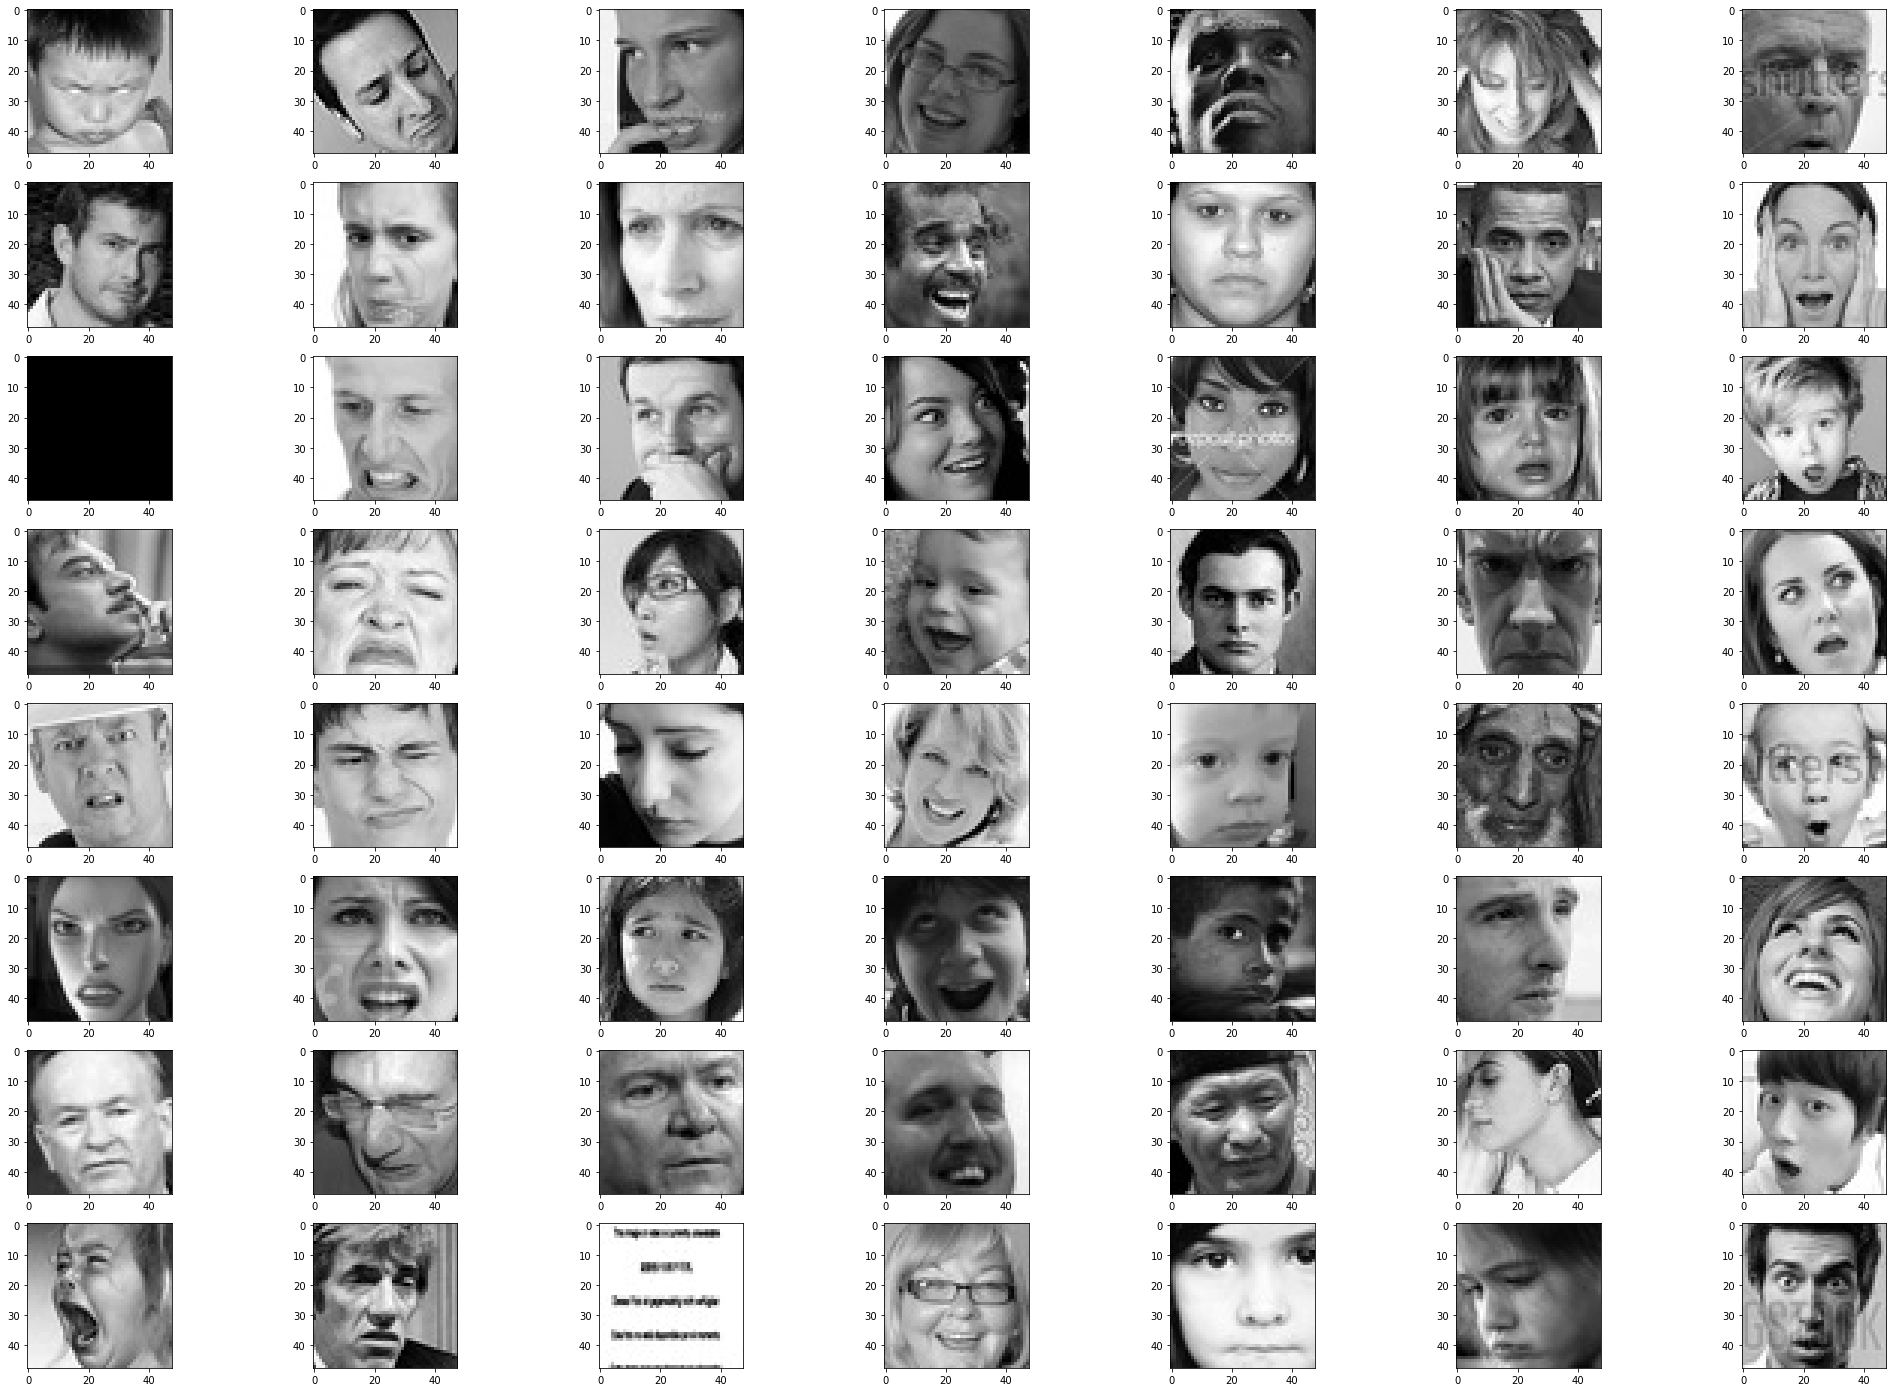

In [3]:
train_dir = "C:\\Users\\pranjali\\LGM\\train\\"
test_dir = "C:\\Users\\pranjali\\LGM\\train\\"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=8, ncols=total_labels, figsize=(35, 25))
for x in range(8):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

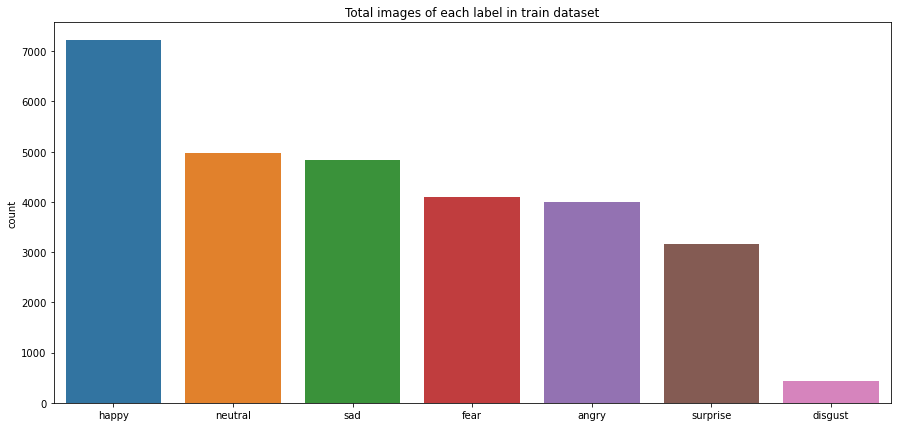

In [4]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(15,7))
sns.barplot(x=df.index, y="total", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

## Data Preprocessing

In [5]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

In [6]:
train_gen = ImageDataGenerator(rescale=1/255,rotation_range=40,width_shift_range=0.2, height_shift_range=0.2,shear_range=0.2,
                               zoom_range=0.2, horizontal_flip=True,fill_mode='nearest')
test_gen = ImageDataGenerator(rescale=1/255)
img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
train_generator = train_gen.flow_from_directory(directory=train_dir,target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',batch_size=64,class_mode='categorical',shuffle=True)
test_generator=test_gen.flow_from_directory(directory=test_dir,target_size=(img_shape[0], img_shape[1]),color_mode='grayscale',
                                              batch_size=64,class_mode='categorical',shuffle=False)

Found 28709 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.


## Building Model

In [7]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0

## Model Training

In [9]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
history = model.fit(train_generator,epochs=20,verbose=1,validation_data=test_generator,steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - 693s 2s/step - loss: 1.8793 - accuracy: 0.2266 - val_loss: 2.0704 - val_accuracy: 0.2607
Epoch 2/20
448/448 [==============================] - 680s 2s/step - loss: 1.8008 - accuracy: 0.2472 - val_loss: 1.7622 - val_accuracy: 0.2786
Epoch 3/20
448/448 [==============================] - 677s 2s/step - loss: 1.7845 - accuracy: 0.2563 - val_loss: 1.7392 - val_accuracy: 0.2976
Epoch 4/20
448/448 [==============================] - 681s 2s/step - loss: 1.7733 - accuracy: 0.2657 - val_loss: 1.6920 - val_accuracy: 0.3156
Epoch 5/20
448/448 [==============================] - 800s 2s/step - loss: 1.7597 - accuracy: 0.2747 - val_loss: 1.6650 - val_accuracy: 0.3291
Epoch 6/20
448/448 [==============================] - 676s 2s/step - loss: 1.7394 - accuracy: 0.2899 - val_loss: 1.6189 - val_accuracy: 0.3511
Epoch 7/20
448/448 [==============================] - 680s 2s/step - loss: 1.7128 - accuracy: 0.3033 - val_loss: 1.5993 - val_accuracy: 0.3715

## Saving Model

In [15]:
model.save("Final_Model.h5")

## Model Testing

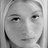

In [22]:
image = cv2.imread("C:\\Users\\pranjali\\LGM\\SAD.jpg")
from IPython.display import Image
Image(filename='C:\\Users\\pranjali\\LGM\\SAD.jpg')

In [20]:
model = tf.keras.models.load_model("Final_Model.h5",custom_objects={'Functional':tf.keras.models.Model})
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
img = image
frame = cv2.resize(img,(48,48),interpolation=cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0
gray = gray.reshape(1,48,48,1)
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i,j) in zip(range(7),EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j)+"prediction rate is   {0:.2f}%".format(predictss))
print( "\n\n The system considers this expression to be:",label)

  Angry   prediction rate is   0.02%
 Disgust  prediction rate is   0.00%
  Happy   prediction rate is   0.00%
   Sad    prediction rate is   0.92%
 Surprise prediction rate is   0.04%
 Neutral  prediction rate is   0.00%


 The system considers this expression to be: Sad


In [23]:
if (label=='Angry'):
    d="Angry.Song"
    print("Now Playing:",d)
elif (label=='Disgust'):
    d="Disgust.song"
    print("Now Playing:",d)
elif (label=="Happy"):
    d="Happy.song"
    print("Now Playing:",d)
elif (label=='Sad'):
    d = "Sad.song"
    print("Now Playing:",d)
elif (label=='Surprise'):
    d = "Surprise.song"
    print("Now Playing:",d)
elif (label=='Neutral'):
    d= "Neutral.song"
    print("Now Playing:",d)

Now Playing: Sad.song


## Model Evaluation 

In [24]:
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

449/449 [==============================] - 139s 309ms/step - loss: 1.2471 - accuracy: 0.5160
validation accuracy : 51.60054564476013%
validation loss : 1.2471134662628174


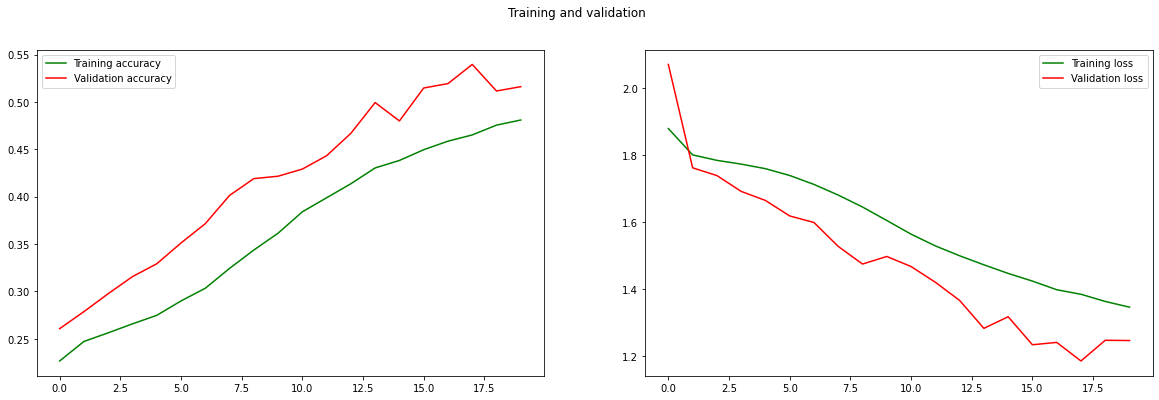

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)
plt.suptitle('Training and validation')
plt.show()

              precision    recall  f1-score   support

       angry       0.44      0.45      0.44      3995
     disgust       0.60      0.01      0.01       436
        fear       0.33      0.37      0.35      4097
       happy       0.69      0.86      0.76      7215
     neutral       0.44      0.55      0.49      4965
         sad       0.52      0.20      0.29      4830
    surprise       0.56      0.50      0.53      3171

    accuracy                           0.52     28709
   macro avg       0.51      0.42      0.41     28709
weighted avg       0.52      0.52      0.50     28709





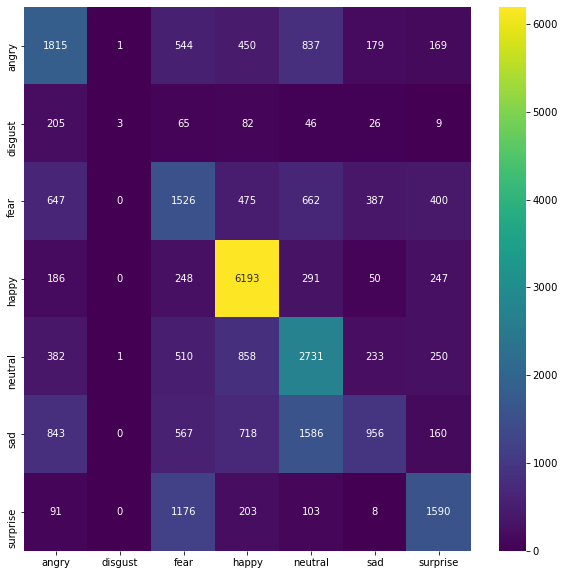

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, cmap=plt.cm.viridis,annot=True, fmt='.0f',xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.show()